# Develop and evaluate neural network models using Keras for a regression problem

__Author - Sarthak Kaushik__

__Date - October 26, 2021__


In [ ]:
from PIL import Image
import glob
import os
import shutil

import random

import pathlib
import tensorflow as tf

from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter("ignore")

# Image Resizing

In [ ]:
def resize_image(img, path, i):
    # Resize and save image
    image = Image.open(img)
    image = image.resize((150,150))
    image.save(path+'/'+str(i)+'.jpg')
    return
        
def create_directory(path):
    # Create directory for resized images
    if os.path.isdir(path) == True:
        print ("directory exists: " + path)
#         print ('deleting directory: ' + path)
        shutil.rmtree(path)
        os.mkdir(path)
        print ("directory created: " + path)
    else :
        os.mkdir(path)
        print ("directory created: " + path)
    return

def resize_images():
    directories = glob.glob('flower_photos/*/')
    path = os.path.join('resized')
    # shutil.rmtree(path)
    create_directory(path)

    for directory in directories:
        flower_type = str.split(directory,'/')[1]    
       # path = os.path.join(path1,'resized',flower_type)
        path2 = os.path.join('resized',flower_type)
        create_directory(path2)
        i = 0
        images= glob.glob(directory+'/*.jpg')
        for image in images:
            resize_image(image, path2 , i)
            i += 1
    shutil.rmtree('flower_photos')
    return

In [ ]:
%%time
# Download Images
!curl -O http://download.tensorflow.org/example_images/flower_photos.tgz
!tar -xf flower_photos.tgz
os.remove("flower_photos.tgz") 
resize_images()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0   212M      0  0:00:01  0:00:01 --:--:--  212M
directory created: resized
directory created: resized/tulips
directory created: resized/daisy
directory created: resized/dandelion
directory created: resized/roses
directory created: resized/sunflowers
CPU times: user 19.8 s, sys: 781 ms, total: 20.5 s
Wall time: 24.4 s


# Split Images Train-Test

In [ ]:
def move_file(original_folder, list_files ,  target_folder) :
#     files = glob.glob(original_folder+'/*.jpg')
#     print(original_folder)
    for image in list_files:
        # print(image)
        # Get file name
        image_name = image.split("/")[2]

        # Move File to Folder
        shutil.move(image, target_folder+"/"+image_name)

In [ ]:
seed = 100
random.seed(seed)

directories = glob.glob('resized/*/')
tr_ratio = 0.75

# Create directories
create_directory('train')
create_directory('validation')

for directory in directories :
    # Split directory to get flower class
    flower_class = directory.split("/")[1]
    flower_name = directory.split("/")[2]

    # Get number files in train and test
    files = glob.glob(directory+'/*.jpg')
    tr_idx = round (tr_ratio * len(files))
    
    # random shuffle images in files
    random.shuffle(files)
    
    #split files into test and train
    train = files[:tr_idx]
    test = files[tr_idx:]

    # Create directory for flower_class under train and test
    train_folder = 'train/'+flower_class
    create_directory(train_folder)
    
    validation_folder = 'validation/'+flower_class
    create_directory(validation_folder)
    
    #move files to train and validation
    move_file(directory, train , train_folder)
    move_file(directory, test ,validation_folder)

shutil.rmtree("resized/")


directory created: train
directory created: validation
directory created: train/tulips
directory created: validation/tulips
directory created: train/daisy
directory created: validation/daisy
directory created: train/dandelion
directory created: validation/dandelion
directory created: train/roses
directory created: validation/roses
directory created: train/sunflowers
directory created: validation/sunflowers


# Train-Validation Configuration

In [ ]:
train_data_dir = 'train/'
validation_data_dir = 'validation/'

image_w, image_h = 150, 150

# set the following parameters as per your preference
batch_size = 30

# Data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 40,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_w, image_h),
    color_mode ='rgb', 
    batch_size=batch_size,
    class_mode='binary',
    seed = 42,)

# rescaling
validation_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_w, image_h),
    color_mode ='rgb', 
    batch_size=batch_size,
    class_mode='binary',
    seed = 42,)

Found 2753 images belonging to 5 classes.
Found 917 images belonging to 5 classes.


# Model VGG16 - Top Layer Removed

In [ ]:
# VGG16 pre-trained model without fully connected layers and with different input dimensions
def model_vgg():
    modelvgg = tf.keras.applications.VGG16(
        weights = "imagenet", 
        include_top=False, 
        input_shape = (image_w, image_h, 3)
    )
    return modelvgg

#model_vgg().summary()

# Functions

## Freezing all layers

In [ ]:
# Freezing all layers we don't want to train
def unfreeze_layers(model, n=0, unfreeze_all = False):
    ''' n : number of layers to freeze'''
    for layer in model.layers:
        layer.trainable = True
    
    # if unfreeze_all == 1 then skip this step
    if unfreeze_all == False:

        # Unfreeze layers as defined by n
        for layer in model.layers[:len(model.layers)-n]:
            layer.trainable = False
    layers = [] 
    for i, layer in enumerate(model.layers): 
            layers.append([layer.name, layer.trainable])
    print (layers)

## Add Fully Connected End Layers

In [ ]:
# Adding custom layers to create a new model 
# one with 256 nodes using ‘relu’ activation and output layer with 5 nodes and ‘softmax’ activation)
# model
def model_custom(frozenLayers = 0,unfreeze_all = False, lr =0.01, dropoutRatio = 0.2, l2Regularizer = 0.01):
    model = model_vgg()
    unfreeze_layers(model, frozenLayers, unfreeze_all)
    model1 = Sequential([
        model,
        Flatten(name='flatten'),
        Dense(256, activation='relu', name='new_fc1', 
              kernel_initializer="HeNormal", 
              kernel_regularizer = regularizers.l2(l2Regularizer)),
        Dropout(dropoutRatio),
        Dense(5, activation='softmax', 
              name='new_predictions')
    ])

    print (model1.summary())

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr,)

    model1.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        optimizer = optimizer, 
        metrics=["accuracy"])

    return model1

## Plot Loss

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  # Get training and test loss histories
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(history):
  # Get training and test loss histories
  training_loss = history.history['accuracy']
  test_loss = history.history['val_accuracy']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
nb_train_samples = 1000
nb_validation_samples = 600

# First Model - No Layers Trainable

In [ ]:
%%time
model1 = model_custom(frozenLayers = 0,unfreeze_all = False,
                      lr = 0.00001, dropoutRatio = 0.2, l2Regularizer = 0.01)

# Basically tune the weights of the newly added fully connected layers
history1 = model1.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

[['input_4', False], ['block1_conv1', False], ['block1_conv2', False], ['block1_pool', False], ['block2_conv1', False], ['block2_conv2', False], ['block2_pool', False], ['block3_conv1', False], ['block3_conv2', False], ['block3_conv3', False], ['block3_pool', False], ['block4_conv1', False], ['block4_conv2', False], ['block4_conv3', False], ['block4_pool', False], ['block5_conv1', False], ['block5_conv2', False], ['block5_conv3', False], ['block5_pool', False]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
__________________________________________________

## Loss Evaluation

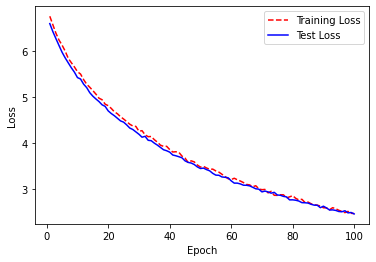

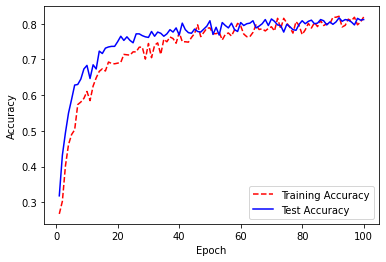

In [ ]:
plot_loss(history1)
plot_accuracy(history1)

## Evaluate Model
- the accuracy on the test model is high compared to the accuracy on the validation set. This indicates significant overfit of the model. 

# Second Model - Last Layer Trainable

## Unfreeze Last Layer (Batch5)

In [ ]:
%%time
model2 = model_custom(frozenLayers = 4,unfreeze_all = False,
                      lr = 0.00001, dropoutRatio = 0.2, l2Regularizer = 0.01)

# Basically tune the weights of the newly added fully connected layers along with the last layer
history2 = model2.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

[['input_5', False], ['block1_conv1', False], ['block1_conv2', False], ['block1_pool', False], ['block2_conv1', False], ['block2_conv2', False], ['block2_pool', False], ['block3_conv1', False], ['block3_conv2', False], ['block3_conv3', False], ['block3_pool', False], ['block4_conv1', False], ['block4_conv2', False], ['block4_conv3', False], ['block4_pool', False], ['block5_conv1', True], ['block5_conv2', True], ['block5_conv3', True], ['block5_pool', True]]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
______________________________________________________

## Loss Evaluation

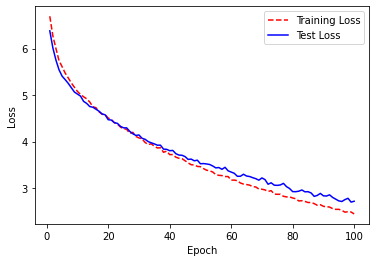

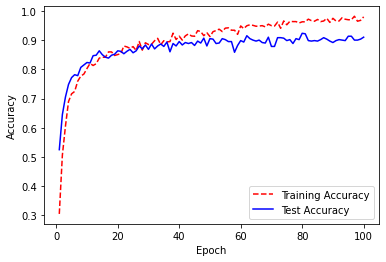

In [ ]:
plot_loss(history2)
plot_accuracy(history2)

## Evaluate Model

# Third Model - All Layers Trainable

## Unfreeze All Layers

In [ ]:
%%time
model3 = model_custom(unfreeze_all = True,
                      lr = 0.00001, dropoutRatio = 0.2, l2Regularizer = 0.01)

# Basically tune the weights of the newly added fully connected layers
history3 = model3.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose = True)

[['input_6', True], ['block1_conv1', True], ['block1_conv2', True], ['block1_pool', True], ['block2_conv1', True], ['block2_conv2', True], ['block2_pool', True], ['block3_conv1', True], ['block3_conv2', True], ['block3_conv3', True], ['block3_pool', True], ['block4_conv1', True], ['block4_conv2', True], ['block4_conv3', True], ['block4_pool', True], ['block5_conv1', True], ['block5_conv2', True], ['block5_conv3', True], ['block5_pool', True]]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dro

## Loss Evaluation

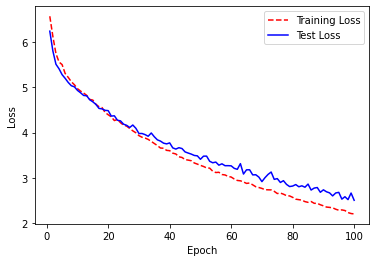

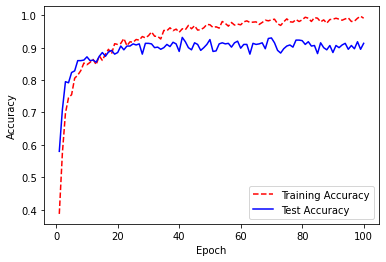

In [ ]:
plot_loss(history3)
plot_accuracy(history3)

## Evaluate Model